In [1]:
import matplotlib.pyplot as plt
from mpi4py import MPI
from eigentools import Eigenproblem, CriticalFinder
import time
import dedalus.public as de
import numpy as np

import scipy.linalg
import scipy.sparse.linalg

In [2]:
z = de.Chebyshev('z', 128)
d = de.Domain([z],comm=MPI.COMM_SELF)

orr_somerfeld = de.EVP(d,['w','wz','wzz','wzzz'],'c')
orr_somerfeld.parameters['alpha'] = 1.
orr_somerfeld.parameters['Re'] = 10000.
#orr_somerfeld.substitutions['sigma'] = '-1j*alpha*Re*c'
orr_somerfeld.substitutions['umean']= '1 - z**2'
orr_somerfeld.substitutions['umeanzz']= '-2'

#orr_somerfeld.add_equation('dz(wzzz) - 2*alpha**2*wzz + alpha**4*w - sigma*(wzz-alpha**2*w)-1j*alpha*(Re*(1-z**2)*(wzz-alpha**2*w) + 2*Re*w) = 0 ')
orr_somerfeld.add_equation('dz(wzzz) - 2*alpha**2*wzz + alpha**4*w -1j*alpha*Re*((umean-c)*(wzz - alpha**2*w) - umeanzz*w) = 0')
orr_somerfeld.add_equation('dz(w)-wz = 0')
orr_somerfeld.add_equation('dz(wz)-wzz = 0')
orr_somerfeld.add_equation('dz(wzz)-wzzz = 0')

orr_somerfeld.add_bc('left(w) = 0')
orr_somerfeld.add_bc('right(w) = 0')
orr_somerfeld.add_bc('left(wz) = 0')
orr_somerfeld.add_bc('right(wz) = 0')

# create an Eigenproblem object
EP = Eigenproblem(orr_somerfeld)

2020-12-12 08:36:21,551 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2020-12-12 08:36:21,612 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [3]:
# Form invariant subspace
k = 100
EP.solve(sparse=True, N=k) # O(N k)?
pre_right = EP.solver.pencils[0].pre_right
pre_right_LU = scipy.sparse.linalg.splu(pre_right.tocsc()) # O(N)
V = pre_right_LU.solve(EP.solver.eigenvectors) # O(N k)

# Orthogonalize invariant subspace
Q, R = np.linalg.qr(V) # O(N k^2)

# Compute approximate Schur factor
mu = 0.25
E = (EP.solver.pencils[0].M_exp)
A = (EP.solver.pencils[0].L_exp)
A_mu_E = A - mu*E
A_mu_E_LU = scipy.sparse.linalg.splu(A_mu_E.tocsc()) # O(N)
Ghat = Q.conj().T @ A_mu_E_LU.solve(E @ Q) # O(N k^2)

# Invert-shift Schur factor
I = np.identity(k)
Gmu = np.linalg.inv(Ghat) + mu*I # O(k^3)

In [4]:
print(np.linalg.cond(Ghat))
print(np.linalg.cond(Gmu))

968.070213293026
2113.185323730622


In [5]:
def pseudo(L, xlim, ylim, size):
    xrange = np.linspace(xlim[0], xlim[1], size)
    yrange = np.linspace(ylim[0], ylim[1], size)
    R = np.zeros((size, size))
    matsize = L.shape[0]
    for j, y in enumerate(yrange):
        for i, x in enumerate(xrange):
            z = x + 1j*y
            R[j, i] = np.linalg.norm((z*np.eye(matsize) - L), ord=-2)
    return R, xrange, yrange

In [6]:
OS_pseudo, OS_x, OS_y = pseudo(Gmu, [-1,0], [-1,1], 100)

In [7]:
EP.solve(sparse=False)

(-1.0, 0.1)

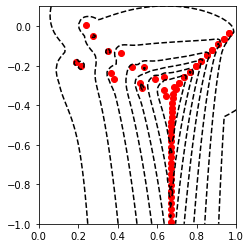

In [8]:
plt.scatter(EP.evalues_low.real, EP.evalues_low.imag,color='red')
plt.contour(-OS_x, -OS_y, np.log10(OS_pseudo),levels=[-8,-7,-6,-5,-4,-3,-2,-1],colors='k')
plt.axis('square')
#plt.colorbar()
plt.xlim(0,1)
plt.ylim(-1,0.1)